In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u

from ctapipe.instrument import CameraGeometry
from ctapipe.visualization import CameraDisplay
from ctapipe.utils import get_dataset_path
from ctapipe.io import EventSource
from ctapipe.calib import CameraCalibrator
from ctapipe.image.cleaning import tailcuts_clean
from ctapipe.image.hillas import hillas_parameters
from copy import deepcopy
import os

/Users/thomasvuillaume/opt/anaconda3/envs/pres_cta/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import ctapipe
ctapipe.__version__

'0.12.0'

In [3]:
# from ctapipe.tools.process import ProcessorTool
# from subprocess import run

# processor = ProcessorTool()
# processor.input_url = get_dataset_path('gamma_test_large.simtel.gz')


# run(['ctapipe-process', '-i', get_dataset_path('gamma_test_large.simtel.gz'), 
#      '-o', 'dl1_gamma_test_large.h5',
#      '--progress',
#      '--write-images',
#      '--overwrite',
#      '--camera-frame',
#     ])

In [4]:
from ctapipe.io.tableloader import read_table
from ctapipe.instrument import SubarrayDescription
from ctapipe.io import TableLoader
from ctapipe.io import HDF5TableReader
from ctapipe.io import dl1eventsource
from ctapipe.image.hillas import HillasParametersContainer
from ctapipe.containers import CameraHillasParametersContainer

In [5]:
dl1_filename = "dl1_gamma_test_large.h5"
subarray = SubarrayDescription.from_hdf(dl1_filename)
geom = subarray.tels[1].camera.geometry

In [6]:
loader = TableLoader(dl1_filename, 
                     load_dl1_images=True, 
                     load_true_images=True,
                     load_true_parameters=True,
                     load_simulated=True,
                     load_instrument=True,
                     load_trigger=True
                    )

In [7]:
tel_type = 'LST_LST_LSTCam'
tel_id = 1
geom = loader.subarray.tels[tel_id].camera.geometry
dl1_events = loader.read_telescope_events_by_type([tel_type])[tel_type]
dl1_events = dl1_events[np.isfinite(dl1_events['hillas_intensity'])]

In [8]:
source = dl1eventsource.DL1EventSource(input_url=dl1_filename)

In [9]:
dl1_events.sort('hillas_intensity', reverse=True)

In [10]:
event_idx = 14
event = dl1_events[event_idx]

In [31]:
len(noisy_image)

1855

In [83]:
image = event['image']

noisy_image = image + 6*np.random.poisson(lam=0.4, size=len(event['image']))

# add dead pixels
pixels_alive = np.random.choice(np.array([False, True]), size=len(noisy_image), p=[0.005, 0.995])
noisy_image[~pixels_alive] = np.nan

In [96]:
## OPTIONS

text_colorbar_color = 'white'
dead_pixels_color = 'white'

cmap = plt.get_cmap("viridis")
cmap.set_bad(color=dead_pixels_color)


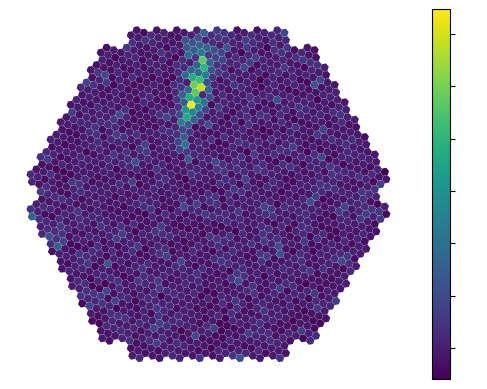

In [97]:
display = CameraDisplay(geom, image, 
                        show_frame=False,
                        # cmap='binary'
                       )


display.add_colorbar()
cbar = display.colorbar
for label in cbar.ax.yaxis.get_ticklabels():
    label.set_color(text_colorbar_color)
    
ax = display.axes
fig = ax.get_figure()
visible_axis=False
ax.get_xaxis().set_visible(visible_axis)
ax.get_yaxis().set_visible(visible_axis)
if not visible_axis:
    ax.axis('off')
    ax.set_title('')
    
plt.savefig(f'event_{event_idx}.png', dpi=150, transparent=True)

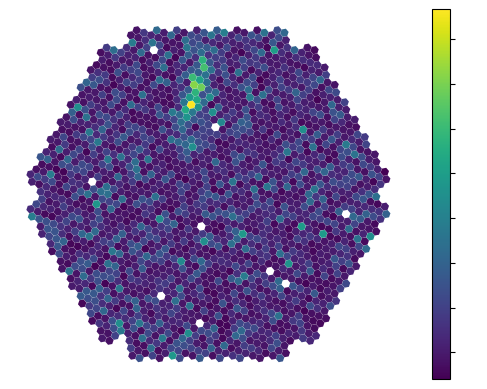

In [99]:
display = CameraDisplay(geom, noisy_image, 
                        show_frame=False,
                        cmap=cmap
                       )

# display.highlight_pixels(~pixels_alive, color='red')
display.add_colorbar()
cbar = display.colorbar
for label in cbar.ax.yaxis.get_ticklabels():
    label.set_color(text_colorbar_color)

ax = display.axes
fig = ax.get_figure()
visible_axis=False
ax.get_xaxis().set_visible(visible_axis)
ax.get_yaxis().set_visible(visible_axis)
if not visible_axis:
    ax.axis('off')
    ax.set_title('')
    
plt.savefig(f'event_{event_idx}_noisy.png', dpi=150, transparent=True)

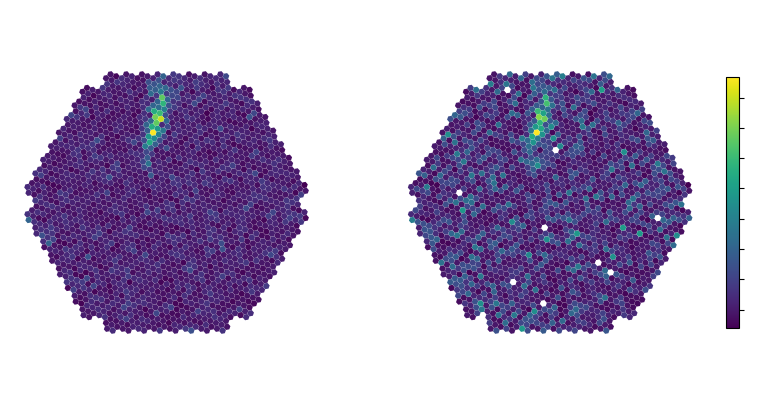

In [100]:
fig, axes = plt.subplots(1, 2, figsize=(10,5), width_ratios=[1,1.25])
import matplotlib.gridspec as gridspec


display = CameraDisplay(geom, image, 
                        show_frame=False,
                        cmap=cmap,
                        ax=axes[0]
                       )

display = CameraDisplay(geom, noisy_image, 
                        show_frame=False,
                        cmap=cmap,
                        ax=axes[1]
                       )

# display.highlight_pixels(~pixels_alive, color='red')
display.add_colorbar(shrink=0.65)
cbar = display.colorbar
for label in cbar.ax.yaxis.get_ticklabels():
    label.set_color(text_colorbar_color)

visible_axis=False
for ax in axes:
    ax.get_xaxis().set_visible(visible_axis)
    ax.get_yaxis().set_visible(visible_axis)
    if not visible_axis:
        ax.axis('off')
        ax.set_title('')
    
plt.savefig(f'event_{event_idx}_noisy_1x2.png', dpi=150, transparent=True)